In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
def get_train_data_from_df(all_data, test_ratio):
  all_data.info()
  cycle = 0
  cycle_list = []

  start = 0

  for i in range(len(all_data) - 1):
      if (all_data['perc_new'][i+1] == 0):
          cycle += 1
          cycle_list.append(all_data.iloc[start:i])
          start = i+1

  random.shuffle(cycle_list)
  
  drop_list = ["n_lgrf", "n_r_grf", "l_ph_ank", "r_ph_ank", "st_sw_phase"]

  source_table = pd.concat(cycle_list, axis=0, ignore_index=True)
  source_table = source_table.drop(drop_list, axis = 1)
  source_table
  x = source_table
  x = x.drop(['perc_new'], axis=1)
  # scaler = MinMaxScaler()
  # x_scaled = scaler.fit_transform(x)
  # x_scaled = pd.DataFrame(x_scaled)

  encode_gait_percentage(source_table, 'perc_new')
  y = source_table[["X","Y"]]
  # data_x = x_scaled
  data_x=x.values
  x.info()
  data_y = y.values.reshape(-1,2)

  X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
  look_back = 10
  fore_cast = 1

  train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
  validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)

  return train_x, train_y, validation_x, validation_y

In [6]:
import random
def get_data_frames_from_files(file_names, subject_dict, subjects):
  file_list=[]
  for i in range (len(file_names)):

      subject = file_names[i].split('_')[0]
      if not subject in subjects:
        continue
      else:
        print(file_names[i])
      leg_len = subject_dict[subject][0]
      weight = subject_dict[subject][1]
      tmp=pd.read_excel(excel_path + file_names[i], sheet_name='Sheet1')
      perc_column = tmp['perc_new']
      tmp = tmp.drop(columns=['perc_new'])
      scaler = MinMaxScaler()

  # Normalize each column separately
      normalized_data = scaler.fit_transform(tmp)
      column_names = tmp.columns

      normalized_df = pd.DataFrame(normalized_data, columns=column_names)

      normalized_df['leg_len']=leg_len
      normalized_df['weight']=weight
      normalized_df['perc_new']= perc_column
      # normalized_df['lcop']=normalized_df['lcop']*100
      # normalized_df['rcop']=normalized_df['rcop']*100
      # normalized_df.insert(tmp.columns.get_loc('col1'), 'perc', perc_column)
      # tmp['l_ph_hip']=tmp['l_ph_hip']/100
      # tmp['lcop']= tmp['lcop']*1000
      # tmp['rcop']=tmp['rcop']*1000
      # tmp['r_ph_hip']=tmp['r_ph_hip']/100
      # tmp['strike_frame']=tmp['strike_frame']/1000;
      file_list.append(normalized_df)

  random.shuffle(file_list)

  all_data = pd.concat(file_list, axis=0, ignore_index=True)
  return all_data


In [7]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
import keras
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        print(x.shape)
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [8]:
class Sampling(L.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        seq = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        epsilon = tf.random.normal(shape=(batch, seq, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def encoder_model():

  x=Input(shape=(seq_len, train_x.shape[2]))
  part_1 = x[:, :, :7]

  part_2 = x[:, :, 7:]
  print(part_2)
  l1=tf.keras.layers.AveragePooling1D(
      pool_size=2,
      strides=1, padding="same")(part_1)
  att1 = attention()(part_1)
  rep_layer = L.RepeatVector((seq_len))(att1)
  # latent_sp=L.TimeDistributed(Dense(4))(rep_layer)
  f1=tf.keras.layers.Flatten()(l1)
  print(l1.shape)
  lstm_inp=L.Concatenate(axis=2)([l1,rep_layer, part_2])
  # RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
  LSTM_layer2 = LSTM(32, return_sequences=True)(lstm_inp)
  # attn_layer1 = attention()(LSTM_layer2)
  mean = L.Dense(3)(LSTM_layer2)
  log_var= L.Dense(3)(LSTM_layer2)
  z = Sampling()([mean, log_var])
  latent_sp=L.TimeDistributed(L.Dense(3))(LSTM_layer2)

  encoder = tf.keras.Model(x, (mean, log_var, z, latent_sp), name="Encoder")
  return encoder

In [10]:
def decoder_model():

  latent_dim =(10,8)
  n_real_features = n_features -2
  input_1_shape=(10,3)
  input_2_shape=( 10,3)
  input_3_shape=( 10,2)
  input1 = tf.keras.Input(shape=input_1_shape, name='input_layer1')
  input2 = tf.keras.Input(shape=input_2_shape, name='input_layer2')
  concat1= L.Concatenate(axis=2)
  concatenated_input = L.Concatenate(axis=2)([input1, input2])
  # pooled_l = L.AveragePooling2D(pool_size=)
  # f=Flatten()(concatenated_input)
  # print(f)
  dec_l1 = L.Dense(8)(concatenated_input)
  # rep_layer = L.RepeatVector((seq_len))(dec_l1);
  dec_LSTM_layer1 = LSTM(32, return_sequences=True)(dec_l1)
  dec_LSTM_layer2 = LSTM(8, return_sequences=True)(dec_LSTM_layer1)

  lin_layer = L.TimeDistributed(L.Dense(n_real_features))(dec_LSTM_layer2)

  # tmp_layer = Flatten()(dec_LSTM_layer)
  # lin_layer = L.Dense(2)(tmp_layer)
  decoder = tf.keras.Model([input1, input2], lin_layer, name="Decoder")
  return decoder


In [11]:
seq_len=10
#encoder_model().summary()
#decoder_model().summary()

from tensorflow import keras


In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, ls = self.encoder(data)
            # inp_dec = tf.concat((z, ls, p2), axis=2)
            # print(inp_dec)
            reconstruction = self.decoder([z,ls])
            # tmp1=keras.losses.binary_crossentropy(data, reconstruction)
            # reconstruction_loss = K.mean(K.square(data - reconstruction))
            mse = tf.keras.losses.MeanSquaredError()
            real_data = data[:,:,0:7]
            reconstruction_loss = mse(real_data, reconstruction)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction)
            #     )
            # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1,2)))
            total_loss = 1.5*reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [13]:
def train_vae(train_x):
  enc=encoder_model()
  dec=decoder_model()
  vae = VAE(enc, dec)
  vae.compile(optimizer=keras.optimizers.Adam())
  vae.fit(train_x, epochs=12, batch_size=128)

  return vae.encoder,vae.decoder

In [14]:
def create_latent_space_train_mlp(encoder, train_x):
  _,_,samp_t, ls_t=encoder.predict(train_x)
  ls_t = tf.concat((samp_t, ls_t), axis=2)
  print('Encoded time-series shape', ls_t.shape)
  return ls_t

In [15]:
def test_model_get_results(encoder, mlp_model, validation_x, validation_y, display_flag):
  _,_,samp_v, ls_v=encoder.predict(validation_x)
  ls_v = tf.concat((samp_v, ls_v), axis=2)
  print('Encoded time-series shape', ls_v.shape)
  testPredict = mlp_model.predict(ls_v)
  print(validation_y.shape)
  print(testPredict.shape)
  testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
  # print(testScore)
  # print('Test Score: %.2f RMSE' % (testScore))
  
  pred = np.zeros((len(testPredict),1))

  for iter in range(len(testPredict)):
    x = testPredict[iter][0]
    y = testPredict[iter][1]
    pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  actual = np.zeros((len(validation_y),1))

  for iter in range(len(validation_y)):
    x =validation_y[iter][0]
    y =validation_y[iter][1]
    actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))
  cor_actual=[]
  cor_pred=[]
  prec_list=[]
  for i in range(5):
    correct = 0
    for iter in range(len(actual)):
      if (actual[iter]>98) or(actual[iter]<3):
        correct+=1
        continue
      if (abs(actual[iter] - pred[iter]) <= (i+1)):
        correct+=1
      cor_pred.append(pred[iter])
      cor_actual.append(actual[iter])
    prec=correct * 100/len(actual)
    print("Precision ", i+1, ": ", prec)
    prec_list.append(prec)
  rmse = 0
  length = len(cor_actual)
  for i in range(len(cor_actual)):

      rmse = rmse + pow(cor_pred[i] - cor_actual[i], 2)
  rmse = rmse / length
  rmse = math.sqrt(rmse)
  if display_flag:
    plt.scatter(cor_actual, cor_pred, facecolors='none', edgecolors='crimson',alpha=0.4)
    p1 = max(max(cor_pred), max(cor_actual))
    p2 = min(min(cor_pred), min(cor_actual))

    ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

    plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
    plt.title('Actual vs Prediction')

  return prec_list, rmse

In [16]:

def train_mlp_model(samp_t, train_y):
  mlp_model = Sequential()

  mlp_model.add(tf.keras.Input(shape=(samp_t.shape[1], samp_t.shape[2]), name='input_layer'))
  mlp_model.add(LSTM(16))

  mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu'))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(samp_t.shape[1]*samp_t.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

  mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
  mlp_model.add(L.Dense(2))
  mlp_model.summary()

  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
  adam = optimizers.Adam(lr_schedule)

  mlp_model.compile(loss='mse', optimizer=adam)

  epochs = 25
  batch=128
  # lrate = LearningRateScheduler(step_decay)
  monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
  # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

  # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
  # train_encoded_reshaped = train_encoded
  callback_list = [monitor]
  mlp_history = mlp_model.fit(samp_t , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=1)

  return mlp_model
# lrate = LearningRateScheduler(step_decay)

In [17]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\TH\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name

c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [18]:
file_names = ['VP_I_0.xlsx', 'VP_I_2.xlsx','VP_I_3.xlsx','VP_I_5.xlsx','VP_I_4.xlsx',
             'SOE_I_0.xlsx', 'SOE_I_2.xlsx','SOE_I_3.xlsx','SOE_I_5.xlsx', 'SOE_I_4.xlsx', 'SD_1_I.xlsx', 'SD_2_I.xlsx',
             'SD_3_I.xlsx','SD_5_I.xlsx','SD_4_I.xlsx','TH_I_0.xlsx', 'TH_I_2.xlsx', 'TH_I_3.xlsx','TH_I_4.xlsx', 'TH_I_5.xlsx'
             ,'PK_0_I.xlsx', 'PK_2_I.xlsx', 'PK_3_I.xlsx','PK_5_I.xlsx',
              'SKS_0_I.xlsx', 'SKS_2_I.xlsx','SKS_3_I.xlsx','SKS_4_I.xlsx','SKS_5_I.xlsx']
subject_dict = {'SKS':[0.73, 0.58],'VP':[0.95, 0.77],'SOE':[0.88, 0.83],'SD':[0.75, 0.70], 'TH':[0.57, 0.52], 'PK':[0.72, 0.88], 
                'JL': [], 'JS': [ư]}
subject_names = [ 'VP','SKS', 'SD','SOE','TH', 'PK']
subject_names = [ 'TH' ]

sub_comb_list=[]
test_sub_list=[]
acc_list=[]
rmse_list=[]
test_acc_list=[]
test_rmse_list=[]
if len(subject_names)==1:
  test_sub_list.append(subject_names[0])
  sub_comb_list.append(subject_names[0])
else:

  for sub in subject_names:

    test_sub_list.append(sub)
    tmp=subject_names.copy()
    tmp.remove(sub)
    sub_comb_list.append(tmp)


In [19]:
for sub_iter,sub_comb in enumerate(sub_comb_list):
  print(sub_comb)
  print(test_sub_list[sub_iter])

TH
TH


Subject combination : TH
TH_I_0.xlsx
TH_I_2.xlsx
TH_I_3.xlsx
TH_I_4.xlsx
TH_I_5.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297989 entries, 0 to 297988
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   n_lcop        297989 non-null  float64
 1   n_rcop        297989 non-null  float64
 2   l_ph_ank      297989 non-null  float64
 3   l_ph_hip      297989 non-null  float64
 4   l_ph_fo       297989 non-null  float64
 5   r_ph_ank      297989 non-null  float64
 6   r_ph_hip      297989 non-null  float64
 7   r_ph_fo       297989 non-null  float64
 8   n_lgrf        297989 non-null  float64
 9   n_r_grf       297989 non-null  float64
 10  st_sw_phase   297989 non-null  float64
 11  strike_frame  297989 non-null  float64
 12  leg_len       297989 non-null  float64
 13  weight        297989 non-null  float64
 14  perc_new      297989 non-null  float64
dtypes: float64(15)
memory usage: 34.1 MB
<class 'pandas

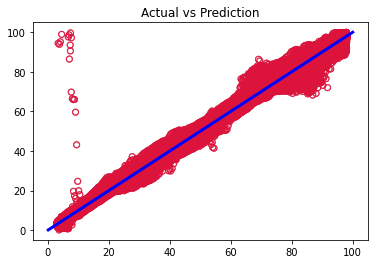

In [20]:
for sub_iter,sub_comb in enumerate(sub_comb_list):
  print("Subject combination :",sub_comb)
  all_data=get_data_frames_from_files(file_names, subject_dict, sub_comb)
  # file_list=[]
  # for sub in sub_comb:
  #   tmp_df=df_dict[sub]
  #   file_list.append(tmp_df)
  # random.shuffle(file_list)
  # all_data = pd.concat(file_list, axis=0, ignore_index=True)
  train_x, train_y, validation_x, validation_y= get_train_data_from_df(all_data, 0.25)
  print(train_x.shape)
  seq_len = train_x.shape[1]
  n_features = train_x.shape[2]

  encoder,decoder = train_vae(train_x)
  samp_t=create_latent_space_train_mlp(encoder, train_x)
  mlp_model = train_mlp_model(samp_t, train_y)
  acc, rmse=test_model_get_results(encoder,mlp_model, validation_x, validation_y, False)
  acc_list.append(acc)
  rmse_list.append(rmse)

  print("testing on :", test_sub_list[sub_iter])
  all_data =get_data_frames_from_files(file_names, subject_dict, [test_sub_list[sub_iter]])
  # all_data = df_dict[test_sub_list[sub_iter]]
  test_x, test_y, validation_x, validation_y = get_train_data_from_df(all_data, 0.25)
  acc, rmse=test_model_get_results(encoder,mlp_model, test_x, test_y, True)
  test_acc_list.append(acc)
  test_rmse_list.append(rmse)
  break

In [21]:
print(test_acc_list)
print(test_rmse_list)

[[53.142250435267705, 78.66670865631622, 90.5766228624644, 95.86326970401797, 97.94400680232323]]
[2.02437700755009]


In [22]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

NameError: name 'actual' is not defined

In [ ]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')